# King County Sales Prediction

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#set display parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# import datafiles
sales = pd.read_csv("kc_house_data_train.csv", index_col = 0)
holdout = pd.read_csv("kc_house_data_test_features.csv", index_col = 0)
filledrooms = pd.read_csv("bedroomsfilled.csv", index_col = 0)

In [3]:
# 
def filled_data(df,df2):
    index=df.loc[df.bedrooms == 0].index.to_list()
    df.drop(df.index[[index]], inplace=True)
    frames= [df, df2]
    train = pd.concat(frames)
    return train
sales=filled_data(sales,filledrooms)

In [4]:
print(sales.shape)
sales.head()

(17290, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [5]:
sales["bedrooms"].median()

3.0

In [6]:
sales["bedrooms"].sort_values(ascending = False)


8597     33
2356     11
3680     10
11181    10
17114    10
         ..
15342     1
7846      1
14292     1
4298      1
9268      1
Name: bedrooms, Length: 17290, dtype: int64

# Function to impute outliers with Median

In [7]:
def cap_max(x, n, data, column):
    """
    x = the column number
    n = min number
    data = dataframe
    column = interested column from dataframe
    should be applied in a lambda function.
    For example: sales["bedrooms"].apply(lambda x: cutoff(x,10,sales,"bedrooms"))
    """
    if x > n:
        return data[column].median()
    else:
        return x
    
def cap_min(x, n, data, column):
    """
    x = the column number
    n = min number
    data = dataframe
    column = interested column from dataframe
    should be applied in a lambda function.
    For example: sales["bedrooms"].apply(lambda x: cutoff(x,10,sales,"bedrooms"))
    """
    if x < n:
        return data[column].median()
    else:
        return x

# Cleaning Bedroom and Bathroom Outliers

In [8]:
sales["bedrooms"]= sales["bedrooms"].apply(lambda x: cap_max(x,10,sales,"bedrooms"))

In [9]:
sales["bedrooms"].sort_values(ascending = False)

3680     10.0
11181    10.0
17114    10.0
14156     9.0
3425      9.0
         ... 
4411      1.0
7474      1.0
11716     1.0
7482      1.0
3186      1.0
Name: bedrooms, Length: 17290, dtype: float64

In [10]:
sales["bathrooms"].sort_values(ascending = True)

9060     0.00
12982    0.00
7093     0.50
4622     0.50
12674    0.50
         ... 
15816    6.75
3425     7.50
7519     7.75
3275     8.00
10366    8.00
Name: bathrooms, Length: 17290, dtype: float64

In [11]:
#sales["bathrooms"]=sales["bathrooms"].apply(lambda x: cap_min(x,0.5,sales,"bathrooms"))

In [12]:
sales["bathrooms"].median()

2.25

In [13]:
sales["bathrooms"].sort_values(ascending = True)

9060     0.00
12982    0.00
7093     0.50
4622     0.50
12674    0.50
         ... 
15816    6.75
3425     7.50
7519     7.75
3275     8.00
10366    8.00
Name: bathrooms, Length: 17290, dtype: float64

In [14]:
sales["month"] = pd.DatetimeIndex(sales["date"]).month
sales.drop(columns=["id","date"], inplace = True)

In [15]:
sales.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,10
1,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,8
2,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,8
3,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,3
4,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,7


In [16]:
corr = sales.corr()

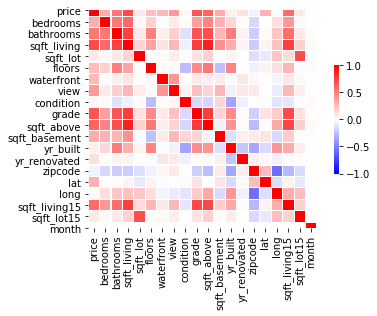

In [17]:
sns.heatmap(corr, cmap="bwr", vmax=1,vmin=-1, center=0, square = True,
             linewidths=.1, cbar_kws={"shrink": .5})

In [18]:
max_threshold = sales.price.quantile(.975)
min_threshold = sales.price.quantile(.025)

In [19]:
sales[sales["price"]>max_threshold].shape

(433, 20)

In [20]:
864/17290

0.04997108155002892

In [21]:
sales[sales["price"]<min_threshold].shape

(421, 20)

In [22]:
sales["price"].max()

7700000.0

In [23]:
sales[sales["price"]==7700000.0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
10366,7700000.0,6.0,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,10


In [24]:
sales.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.372412,2.112854,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.791498,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824,6.570561
std,3.733190e+05,0.906370,0.769820,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343734,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583,3.116999
min,7.500000e+04,1.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,1.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000,4.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000,6.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000,9.000000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000,12.000000


In [25]:
sales.price.max()

7700000.0

In [26]:
sales[sales.price == 7700000.0]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
10366,7700000.0,6.0,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,10


In [27]:
zipcode_df=sales.groupby(sales.zipcode)["price","bedrooms","bathrooms","view", "sqft_living", "sqft_lot"].median()

In [28]:
zipcode_df

,price,bedrooms,bathrooms,view,sqft_living,sqft_lot
zipcode,,,,,,
98001,261000.0,3.0,2.000,0.0,1810.0,9287.0
98002,229950.0,3.0,1.750,0.0,1550.0,7265.0
98003,265000.0,3.0,2.250,0.0,1772.5,8806.5
98004,1208000.0,4.0,2.500,0.0,2770.0,11894.0
98005,761225.0,4.0,2.375,0.0,2520.0,12285.0
98006,753000.0,4.0,2.500,0.0,2660.0,10440.0
98007,542250.0,4.0,2.250,0.0,1950.0,8876.0
98008,550000.0,4.0,2.000,0.0,2000.0,8775.0
98010,362500.0,3.0,2.000,0.0,1985.0,19109.0


In [29]:
zipcode_df.price.max()


1892500.0

In [30]:
zipcode_df[zipcode_df.price == 1892500.0] #zipcode 98039 could be the winnder... 

,price,bedrooms,bathrooms,view,sqft_living,sqft_lot
zipcode,,,,,,
98039,1892500.0,4.0,3.0,0.0,3595.0,16818.5


In [31]:
# with sns.plotting_context("notebook",font_scale=2.5):
#     g = sns.pairplot(sales[['sqft_lot','sqft_above','price','sqft_living','bedrooms', 'month']], size=6)
# g.set(xticklabels=[]);

In [32]:
categorical =['bedrooms', 'view', 'waterfront', 'bathrooms', 'floors','condition',
              'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'month']
non_cat = ['sqft_living','sqft_lot','sqft_above', 'sqft_basement','sqft_living15', 'sqft_lot15']
target = "price"
predictor = "Mix of categorical and non categorical"

In [33]:
print(len(categorical))
print(len(non_cat))

13
6


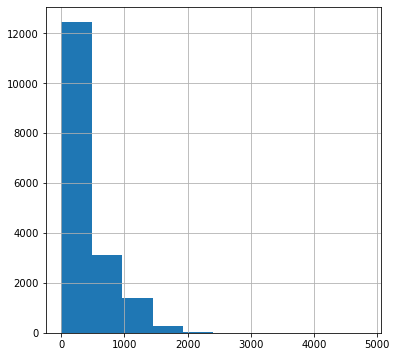

In [34]:
sales["sqft_basement"].hist(figsize  = [6, 6]);

# Log Transform the Contineous variables to normalize the scale

In [35]:
def log_function(data):
    
    
    """ applies np.log to the contineous variables of 
    sqft_above, sqft_living, sqft_living15, sqft_lot, sqft_lot15 
    and returns in a histogram"""
    
    
    data_log = pd.DataFrame([])
    data_log['log_above'] = np.log(data['sqft_above'])
    data_log['log_living'] = np.log(data['sqft_living'])
    data_log['log_living15'] = np.log(data['sqft_living15'])
    data_log['log_lot'] = np.log(data['sqft_lot'])
    data_log['log_lot15'] = np.log(data['sqft_lot15'])
    return data_log.hist(figsize  = [6, 6]);
    

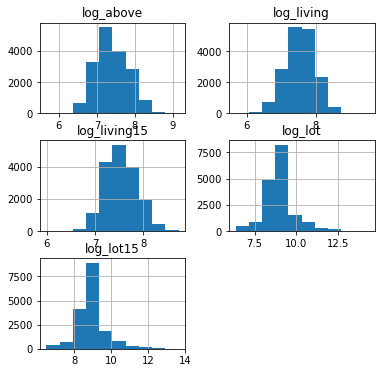

In [36]:
log_function(sales);

In [37]:
data_log = pd.DataFrame([])
data_log['log_above'] = np.log(sales['sqft_above'])
data_log['log_living'] = np.log(sales['sqft_living'])
data_log['log_living15'] = np.log(sales['sqft_living15'])
data_log['log_lot'] = np.log(sales['sqft_lot'])
data_log['log_lot15'] = np.log(sales['sqft_lot15'])


# scaled_above= (log_above - np.mean(log_above)) / np.sqrt(np.var(log_above))
# scaled_living = (log_living - np.mean(log_living)) / np.sqrt(np.var(log_living))
# scaled_lot = (log_lot - np.mean(log_lot)) / np.sqrt(np.var(log_lot))
# scaled_lot15 = (log_lot15 - np.mean(log_lot15)) / (max(log_lot15) - min(log_lot15))

# data_cont_scaled = pd.DataFrame([])
# data_cont_scaled['std_above'] = scaled_above
# data_cont_scaled['std_living'] = scaled_living
# data_cont_scaled['std_lot'] = scaled_lot
# data_cont_scaled['mean_norm_lot15'] = scaled_lot15

## Creating Dummies for Categorial variables of interest

In [38]:
waterfront_dummies = pd.get_dummies(sales["waterfront"], prefix="wfront",  drop_first = True)
view_dummies = pd.get_dummies(sales["view"], prefix="view", drop_first = True)
grade_dummies = pd.get_dummies(sales["grade"], prefix="grade",  drop_first = True)
zipcode_dummies = pd.get_dummies(sales["zipcode"], prefix="zipcode",  drop_first = True)
bedroom_dummies = pd.get_dummies(sales["bedrooms"], prefix="rooms",  drop_first = True)
bathroom_dummies = pd.get_dummies(sales["bathrooms"], prefix="bathrooms", drop_first = True)
month_dummies = pd.get_dummies(sales["month"], prefix="month", drop_first = True)

price = sales["price"]

data_fin = pd.concat([price, data_log, waterfront_dummies, view_dummies, grade_dummies,zipcode_dummies, bedroom_dummies, bathroom_dummies, month_dummies], axis=1)

In [39]:
data_fin.shape

(17290, 140)

In [40]:
data_fin.head()

,price,log_above,log_living,log_living15,log_lot,log_lot15,wfront_1,view_1,view_2,view_3,view_4,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,rooms_2.0,rooms_3.0,rooms_4.0,rooms_5.0,rooms_6.0,rooms_7.0,rooms_8.0,rooms_9.0,rooms_10.0,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,365000.0,7.635304,7.635304,7.779049,9.093020,8.948976,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,865000.0,7.512071,7.972466,7.770645,8.814330,8.745603,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1038000.0,8.234830,8.234830,8.218787,9.295876,9.178334,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1490000.0,8.425078,8.425078,8.306472,9.589325,9.562827,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,711000.0,7.843849,7.843849,7.718685,8.589700,8.306472,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Train Test Split

In [41]:

X = data_fin.drop(columns = "price")
y = data_fin.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

# Sklearn Linear Regression Analysis

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)

print(model_score)
print(mse)
print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))


-1.6100017807272538e+18
2.280859746715679e+29
Mae:  59006.0
R Square               :  -1.6100017807272538e+18
Root Mean Squared Error:  477583474035239.1


In [43]:
josh_pred = multi_lr_model.predict(X_train)

In [44]:

RMSE = metrics.mean_squared_error(y_train, josh_pred)
print(np.sqrt(RMSE))

153701.31849577307


In [45]:
print(len(sales))
np.sqrt(len(sales))

17290


131.49144458861193

In [46]:
# outcome = data_fin.price.values
# predictors = dropped_price.values
# pred_sum = "+".join(predictors.values)
# formula = outcome + "~" + pred_sum

formula = "price ~ data_log+ waterfront_dummies+view_dummies+grade_dummies+zipcode_dummies+bedroom_dummies+bathroom_dummies+ month_dummies"
model = ols(formula= formula, data=data_fin).fit()
model.summary() 




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     606.5
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:14:33   Log-Likelihood:            -2.3100e+05
No. Observations:               17290   AIC:                         4.623e+05
Df Residuals:                   17150   BIC:                         4.634e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.955e+06   2.07e+05     -9.460      0.000   -2.36e+06   -1.55e+06
data_log[0]           6.781e+04   6479.733     10.465      0.000    5.51e+04    8.05e+04
data_log[1]           1.865e+05   7739.366     24.102      0.000    1.71e+05    2.02e+05
data_log[2]           4.454e+04   6457.073      6.898      0.000    3.19e+04    5.72e+04
data_log[3]           3.699e+04   3420.441     10.813      0.000    3.03e+04    4.37e+04
data_log[4]           -1.06e+04   3818.487     -2.777      0.005   -1.81e+04   -3118.628
waterfront_dummies    6.032e+05   1.68e+04     35.965      0.000     5.7e+05    6.36e+05
view_dummies[0]       8.808e+04   9819.738      8.969      0.000    6.88e+04    1.07e+05
view_dummies[1]       7.714e+04   5946.488     12.972      0.000    6.55e+04    8.88e+04
view_dummies[2]       1.442e+05   8133.844     17.723      0.000    1.28e+05     1.6e+05
view_dummies[3]       2.889e+05   1.22e+04     23.593      0.000    2.65e+05    3.13e+05
grade_dummies[0]     -4.854e+04   2.01e+05     -0.242      0.809   -4.42e+05    3.45e+05
grade_dummies[1]     -8.898e+04    1.6e+05     -0.558      0.577   -4.02e+05    2.24e+05
grade_dummies[2]     -1.682e+05   1.58e+05     -1.067      0.286   -4.77e+05    1.41e+05
grade_dummies[3]     -1.843e+05   1.57e+05     -1.170      0.242   -4.93e+05    1.24e+05
grade_dummies[4]     -1.921e+05   1.58e+05     -1.219      0.223   -5.01e+05    1.17e+05
grade_dummies[5]     -1.669e+05   1.58e+05     -1.059      0.289   -4.76e+05    1.42e+05
grade_dummies[6]     -7.854e+04   1.58e+05     -0.498      0.618   -3.88e+05    2.31e+05
grade_dummies[7]      5.962e+04   1.58e+05      0.378      0.706    -2.5e+05    3.69e+05
grade_dummies[8]      2.844e+05   1.58e+05      1.799      0.072   -2.54e+04    5.94e+05
grade_dummies[9]      7.176e+05   1.59e+05      4.509      0.000    4.06e+05    1.03e+06
grade_dummies[10]     1.711e+06   1.67e+05     10.231      0.000    1.38e+06    2.04e+06
zipcode_dummies[0]    2.149e+04   1.54e+04      1.393      0.164   -8743.635    5.17e+04
zipcode_dummies[1]    1593.9115   1.38e+04      0.116      0.908   -2.55e+04    2.86e+04
zipcode_dummies[2]    8.096e+05   1.38e+04     58.652      0.000    7.83e+05    8.37e+05
zipcode_dummies[3]    3.245e+05   1.61e+04     20.187      0.000    2.93e+05    3.56e+05
zipcode_dummies[4]    2.788e+05   1.23e+04     22.686      0.000    2.55e+05    3.03e+05
zipcode_dummies[5]    2.715e+05   1.68e+04     16.191      0.000    2.39e+05    3.04e+05
zipcode_dummies[6]    2.837e+05   1.38e+04     20.532      0.000    2.57e+05    3.11e+05
zipcode_dummies[7]    6.075e+04   2.02e+04      3.005      0.003    2.11e+04       1e+05
zipcode_dummies[8]    1.461e+05   1.52e+04      9.608      0.000    1.16e+05    1.76e+05
zipcode_dummies[9]    8.181e+04   1.81e+04      4.519    

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_hat)
print(np.sqrt(RMSE))

477583474035239.1


In [48]:
print(y_test[-10:])
print(y_pred[-10:])

16820     559000.0
13075     543000.0
15592     365000.0
11703     439000.0
7729      450000.0
830       320000.0
3673      975000.0
9603      738000.0
13300    1205000.0
12385     290000.0
Name: price, dtype: float64
[ 565692.  587308.  618976.  342804.  469872.  506680. 1334532.  781412.
 1058204.  208012.]


In [49]:
sorted(y_pred, reverse=True)

[2.8084182384903096e+16,
 440178161424.0,
 3451264.0,
 3299388.0,
 2937000.0,
 2704424.0,
 2659020.0,
 2615284.0,
 2575416.0,
 2530904.0,
 2511904.0,
 2502360.0,
 2483356.0,
 2458224.0,
 2452708.0,
 2401008.0,
 2384840.0,
 2188108.0,
 2156716.0,
 2147184.0,
 2136936.0,
 2096868.0,
 1986324.0,
 1949192.0,
 1942720.0,
 1939492.0,
 1926960.0,
 1896796.0,
 1880712.0,
 1819996.0,
 1786596.0,
 1763844.0,
 1754216.0,
 1747560.0,
 1719676.0,
 1686092.0,
 1682076.0,
 1679556.0,
 1661252.0,
 1637584.0,
 1634068.0,
 1627172.0,
 1624420.0,
 1612828.0,
 1607584.0,
 1573168.0,
 1563368.0,
 1558240.0,
 1555640.0,
 1551804.0,
 1547912.0,
 1526440.0,
 1525380.0,
 1522116.0,
 1514804.0,
 1505324.0,
 1493240.0,
 1490080.0,
 1489896.0,
 1480480.0,
 1469956.0,
 1461500.0,
 1460800.0,
 1458300.0,
 1453336.0,
 1451404.0,
 1438832.0,
 1437956.0,
 1426184.0,
 1422856.0,
 1416928.0,
 1415568.0,
 1403776.0,
 1399216.0,
 1397640.0,
 1397292.0,
 1395572.0,
 1395372.0,
 1392148.0,
 1390696.0,
 1379000.0,
 1371352.0

In [50]:
X_test["predictions"] = y_pred

In [51]:
X_test.sort_values("predictions", ascending = False)

,log_above,log_living,log_living15,log_lot,log_lot15,wfront_1,view_1,view_2,view_3,view_4,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,rooms_2.0,rooms_3.0,rooms_4.0,rooms_5.0,rooms_6.0,rooms_7.0,rooms_8.0,rooms_9.0,rooms_10.0,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,predictions
10067,5.669881,5.669881,7.390181,9.946308,10.036706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.808418e+16
3425,8.306472,8.306472,7.277939,8.780173,8.259976,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,4.401782e+11
5039,8.517193,8.907883,8.371011,10.119768,10.111274,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.451264e+06
3193,8.735525,8.884610,7.893572,12.316997,8.934982,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.299388e+06
10366,9.056023,9.396820,8.278936,10.225571,9.082507,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2.937000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,6.63331

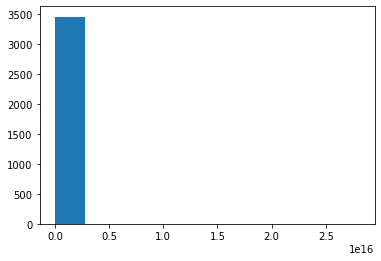

In [52]:
plt.hist(y_hat-y_test);

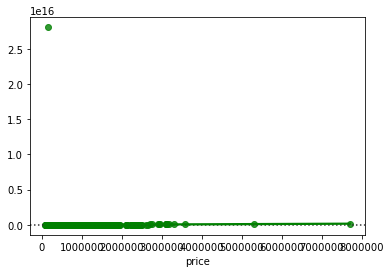

In [53]:
sns.residplot(y_test, y_hat, lowess = True, color = "g");